In [1]:
import pandas as pd
import re
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

# Ensure nltk resources are available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Load dataset
df = pd.read_csv("C:/Users/Mike/Downloads/transformed_dataset.csv", encoding="utf-8", encoding_errors="ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df.head()

,Answer,mean_score
0,"My family was the most salient part of my day,...",7.0
1,Yoga keeps me focused. I am able to take some ...,7.0
2,"Yesterday, my family and I played a bunch of b...",8.0
3,"Yesterday, I visited my parents and had dinner...",8.0
4,"Yesterday, I really felt the importance of my ...",9.0


In [3]:
df.isnull().sum()

Answer        0
mean_score    0
dtype: int64

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)    # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords & lemmatize
    return " ".join(tokens)
# Apply preprocessing
df['cleaned_journal'] = df['Answer'].astype(str).apply(preprocess_text)

# Prepare tokenized format for Word2Vec
tokenized_text = df['cleaned_journal'].apply(word_tokenize).tolist()

In [5]:
tokenized_text

[['family',
  'salient',
  'part',
  'day',
  'since',
  'day',
  'care',
  'child',
  'occupies',
  'majority',
  'time',
  'year',
  'old',
  'month',
  'love',
  'also',
  'require',
  'much',
  'attention',
  'anxiety',
  'higher',
  'ever',
  'often',
  'overwhelmed',
  'care',
  'require',
  'excited',
  'see',
  'hit',
  'developmental',
  'social',
  'milestone'],
 ['yoga',
  'keep',
  'focused',
  'able',
  'take',
  'time',
  'breath',
  'work',
  'body',
  'important',
  'set',
  'mood',
  'whole',
  'day'],
 ['yesterday',
  'family',
  'played',
  'bunch',
  'board',
  'game',
  'husband',
  'surprising',
  'least',
  'played',
  'sort',
  'game',
  'including',
  'life',
  'clue',
  'mouse',
  'trap',
  'relaxing',
  'happy',
  'fun',
  'filled',
  'moment'],
 ['yesterday',
  'visited',
  'parent',
  'dinner',
  'seen',
  'week',
  'wonderful',
  'see',
  'catch',
  'thing'],
 ['yesterday',
  'really',
  'felt',
  'importance',
  'health',
  'went',
  'bit',
  'longer',
  

In [6]:
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
word2vec_vectors = [word2vec_model.wv[text].mean(axis=0) if text else [0]*100 for text in tokenized_text]
df['word2vec_embedding'] = word2vec_vectors

In [7]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(df['cleaned_journal'])
df_count = pd.DataFrame(X_count.toarray(), columns=vectorizer.get_feature_names_out())

In [8]:
print(df[['cleaned_journal', 'word2vec_embedding']].head())


                                     cleaned_journal  \
0  family salient part day since day care child o...   
1  yoga keep focused able take time breath work b...   
2  yesterday family played bunch board game husba...   
3  yesterday visited parent dinner seen week wond...   
4  yesterday really felt importance health went b...   

                                  word2vec_embedding  
0  [-0.10475805, 0.24184854, -0.0014786514, 0.029...  
1  [-0.13632801, 0.31462997, -0.0041431603, 0.037...  
2  [-0.080984734, 0.19112779, -0.0033451035, 0.02...  
3  [-0.12833543, 0.30176747, -0.0047362805, 0.038...  
4  [-0.11944093, 0.27557606, -0.00053243834, 0.03...  


In [9]:
print(df_count.head())

   ab  abbie  ability  able  absolute  absolutely  abundant  abuse  abusing  \
0   0      0        0     0         0           0         0      0        0   
1   0      0        0     1         0           0         0      0        0   
2   0      0        0     0         0           0         0      0        0   
3   0      0        0     0         0           0         0      0        0   
4   0      0        0     0         0           0         0      0        0   

   acadeic  ...  younger  youngest  youtube  ysterday  yummy  zeal  zero  \
0        0  ...        0         0        0         0      0     0     0   
1        0  ...        0         0        0         0      0     0     0   
2        0  ...        0         0        0         0      0     0     0   
3        0  ...        0         0        0         0      0     0     0   
4        0  ...        0         0        0         0      0     0     0   

   zone  zumba  zuri  
0     0      0     0  
1     0      0     0  

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_journal'])

# Define target variable
y = df['mean_score']  # Assuming 'score' is the productivity score column

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Ridge Regression Model
ridge_model = Ridge(alpha=.5)  # Alpha controls regularization strength
ridge_model.fit(X_train, y_train)

# Predict on Test Set
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate Model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Regression MSE: {mse_ridge}")


NameError: name 'df' is not defined

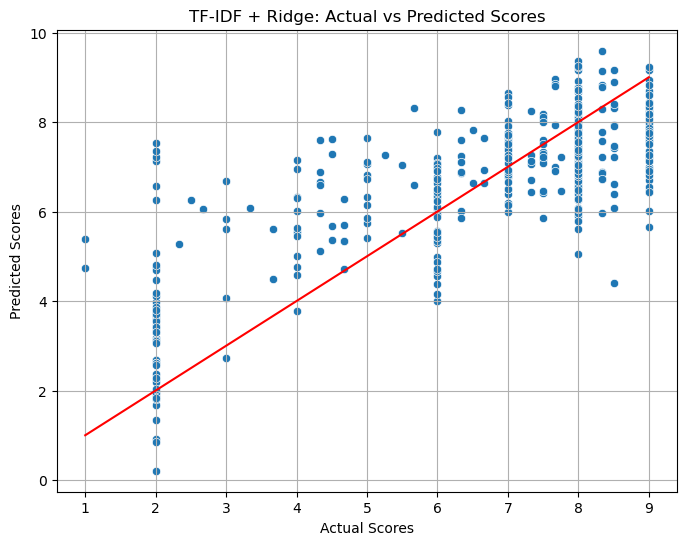

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_ridge)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('TF-IDF + Ridge: Actual vs Predicted Scores')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.grid(True)
plt.show()

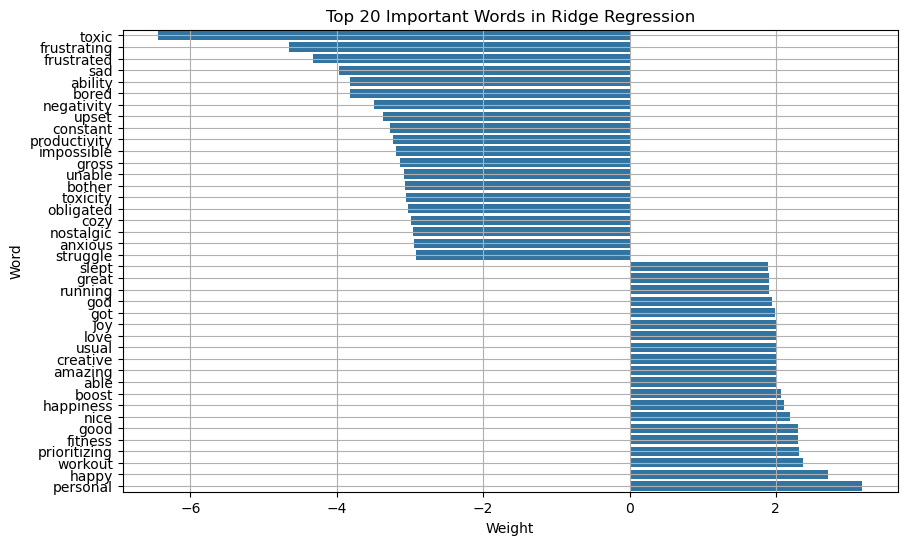

In [12]:
import numpy as np
feature_names = vectorizer.get_feature_names_out()
coef = ridge_model.coef_

top_pos_indices = np.argsort(coef)[-20:]
top_neg_indices = np.argsort(coef)[:20]

top_features = np.concatenate((top_neg_indices, top_pos_indices))
top_words = feature_names[top_features]
top_weights = coef[top_features]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_weights, y=top_words)
plt.title("Top 20 Important Words in Ridge Regression")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.grid(True)
plt.show()

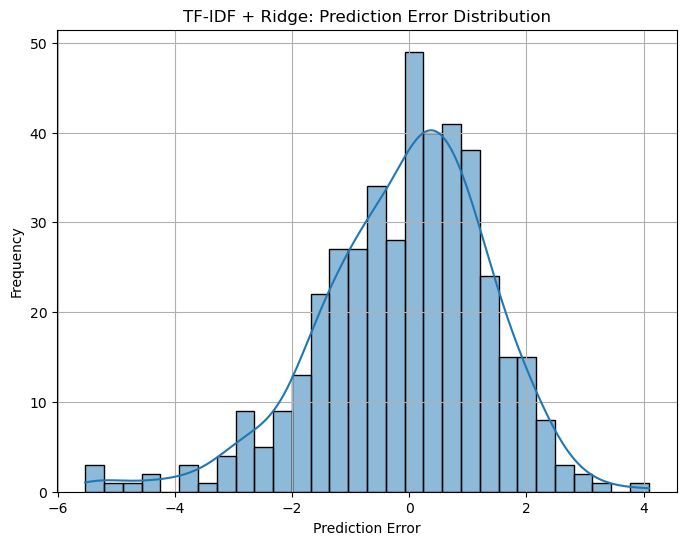

In [13]:
errors = y_test - y_pred_ridge

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title("TF-IDF + Ridge: Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare your data
# You already have this:
tokenized_text = df['cleaned_journal'].apply(word_tokenize).tolist()

# Word2Vec sentence embeddings
X_lstm = np.array([word2vec_model.wv[text].mean(axis=0) if text else np.zeros(100) for text in tokenized_text])

# Normalize the target
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(np.array(df['mean_score']).reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)

# Reshape to fit LSTM input: (batch_size, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Build complex LSTM model
model = Sequential([
    Input(shape=(1, 100)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output
])

# Compile
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# Train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error
print("LSTM MSE:", mean_squared_error(y_test, y_pred))


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.4179 - val_loss: 0.1434
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1179 - val_loss: 0.1075
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0984 - val_loss: 0.1052
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0965 - val_loss: 0.0974
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0969 - val_loss: 0.0906
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0984 - val_loss: 0.0920
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0844 - val_loss: 0.0927
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0888 - val_loss: 0.0873
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0867 - val_loss: 0.0873
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0918 - val_loss: 0.0868
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0859 - val_loss: 0.0861
Epoch 12/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0846 - val_l

In [15]:
# Clean the journal text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

df['tokenized'] = df['Answer'].apply(preprocess_text)

In [16]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokenized'], vector_size=100, window=5, min_count=1, workers=4)

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Create sequence of vectors (each journal as list of vectors)
def get_vector_sequence(tokens):
    vectors = []
    for token in tokens:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    return vectors

vector_sequences = [get_vector_sequence(tokens) for tokens in df['tokenized']]

def pad_sequence(seq, maxlen=100, dim=100):
    if len(seq) < maxlen:
        seq = seq + [np.zeros(dim)] * (maxlen - len(seq))
    else:
        seq = seq[:maxlen]
    return np.array(seq)

X = np.array([pad_sequence(seq, maxlen=100, dim=100) for seq in vector_sequences])

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y = scaler.fit_transform(np.array(df['mean_score']).reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(tf.keras.layers.Layer):
    def __init__(self, return_attention=False):
        super(Attention, self).__init__()
        self.return_attention = return_attention
        self.attention_dense = tf.keras.layers.Dense(1)

    def call(self, lstm_output):
        # Shape: (batch_size, time_steps, hidden_dim)
        e = self.attention_dense(lstm_output)
        alpha = tf.nn.softmax(e, axis=1)  # Attention weights
        context = tf.reduce_sum(alpha * lstm_output, axis=1)
        
        if self.return_attention:
            return context, tf.squeeze(alpha, -1)  # Remove last dim for shape (batch, time)
        return context


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class Attention(Layer):
    def __init__(self, return_attention=False):
        super().__init__()  # 👈 No kwargs here — this avoids the 2-arg error
        self.return_attention = return_attention
        self.attention_dense = Dense(1)

    def call(self, inputs):
        # inputs: (batch_size, time_steps, hidden_size)
        e = self.attention_dense(inputs)  # (batch_size, time_steps, 1)
        alpha = tf.nn.softmax(e, axis=1)  # (batch_size, time_steps, 1)
        context = tf.reduce_sum(alpha * inputs, axis=1)  # (batch_size, hidden_size)

        if self.return_attention:
            return context, tf.squeeze(alpha, -1)  # (batch_size, time_steps)
        else:
            return context

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

maxlen = 100  # sequence length
embedding_dim = 100
# Input
input_layer = Input(shape=(maxlen, embedding_dim))

# LSTM layers
x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
x = LayerNormalization()(x)
x = LSTM(64, return_sequences=True, 
         kernel_regularizer=regularizers.l2(0.001), 
         dropout=0.3, recurrent_dropout=0.3)(x)

# Attention
attention = Attention(return_attention=True)
context_vector, attention_weights = attention(x)

# Output
x = Dense(64, activation='relu')(context_vector)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x)

# Models
model = Model(inputs=input_layer, outputs=output)
attention_model = Model(inputs=input_layer, outputs=attention_weights)

# Compile
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 100, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ [(None, 64), (None,    │            65 │
│                                 │ 100)]                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,434 (540.76 KB)

 Trainable params: 138,434 (540.76 KB)

 Non-trainable params: 0 (0.00 B)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

Input = Input(shape=(maxlen, 100))
x = Bidirectional(LSTM(64, return_sequences=True))(Input)
x = (LayerNormalization())(x)
x = (LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, recurrent_dropout=0.3))(x)
attention = Attention(return_attention=True)
context_vector, attention_weights = attention(x)
x = (Dense(64, activation='relu'))(context_vector)
x = (Dropout(0.3))(x)
output = (Dense(1, activation = 'linear'))(x)


model = Model([Input, output])
attention_model = Model(inputs=input_layer, outputs=attention_weights)

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()

In [23]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

# Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error
print("LSTM + Attention MSE:", mean_squared_error(y_test, y_pred))


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - loss: 0.3225 - val_loss: 0.2108
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.2186 - val_loss: 0.1745
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.1827 - val_loss: 0.1512
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.1616 - val_loss: 0.1356
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.1445 - val_loss: 0.1259
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.1381 - val_loss: 0.1169
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.1266 - val_loss: 0.1184
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.1275 - val_loss: 0.1096
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.1192 - val_loss: 0.1071
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.1209 - val_loss: 0.1010
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.1084 - val_loss: 0.0987
Epoch 12/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/ste

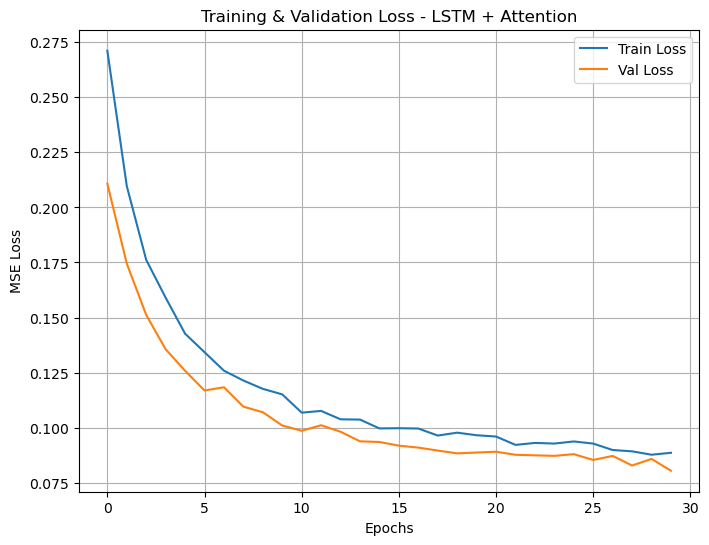

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss - LSTM + Attention')
plt.legend()
plt.grid(True)
plt.show()

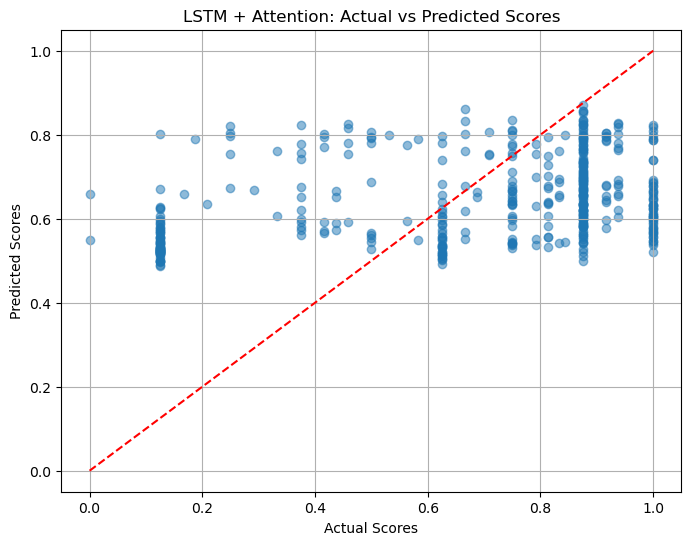

R² Score: 0.10735862022570708


In [25]:
from sklearn.metrics import r2_score

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("LSTM + Attention: Actual vs Predicted Scores")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)],
         color='red', linestyle='--')
plt.grid(True)
plt.show()

print("R² Score:", r2_score(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


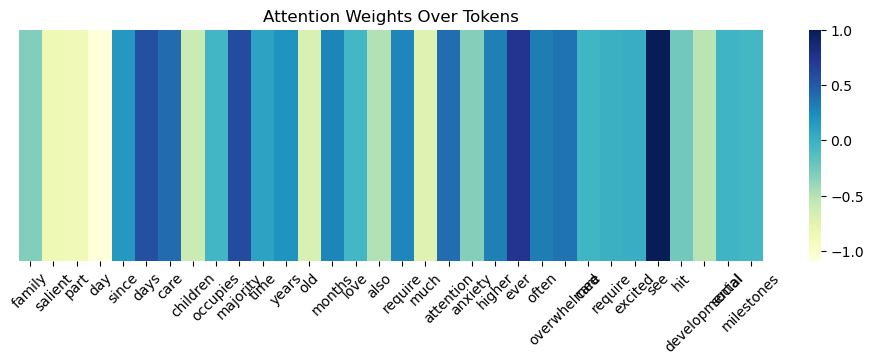

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Build a model to extract attention outputs
from tensorflow.keras.models import Model

# Input layer output
attention_layer_model = Model(inputs=model.input, outputs=model.layers[2].output)  # Attention layer

# Choose a sample
sample_idx = 0
sample_input = X_test[sample_idx:sample_idx+1]
tokens = df['tokenized'].iloc[sample_idx][:maxlen]

# Predict attention weights (e is before softmax, we use attention weight directly)
attention_output = attention_layer_model.predict(sample_input)
attention_weights = attention_output.flatten()

# Normalize weights for better visibility
attention_weights = attention_weights[:len(tokens)]
attention_weights /= attention_weights.max()

# Plot attention over tokens
plt.figure(figsize=(12, 3))
sns.heatmap([attention_weights], xticklabels=tokens, cmap="YlGnBu", cbar=True)
plt.title("Attention Weights Over Tokens")
plt.yticks([])
plt.xticks(rotation=45)
plt.show()

In [27]:
sentence = ' In my work environment, positivity fuels every project. The energetic atmosphere and a commitment to continuous improvement ensure that success and happiness go hand in hand. '

In [28]:
def predict_productivity_score(input_sentence):
    tokens = preprocess_text(input_sentence)
    vector_seq = get_vector_sequence(tokens)
    padded_seq = pad_sequence(vector_seq, maxlen=100, dim=100)
    input_data = np.expand_dims(padded_seq, axis=0)  # Add batch dimension

    prediction = model.predict(input_data)[0][0]  # Assuming output shape (1, 1)

    # Optional: If your y was scaled, inverse_transform here
    prediction = scaler.inverse_transform([[prediction]])[0][0]

    return prediction

In [29]:
randi = predict_productivity_score(sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [30]:
print(randi)

6.761931419372559


In [31]:
!pip install pydot
from tensorflow.keras.utils import plot_model

In [32]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [33]:

plot_model(model, to_file='C:/Users/Mike/Desktop/model_plot.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
